In [1]:

import matplotlib.pyplot as plt
import os
import numpy as np
import rasterio
from pyproj import Transformer
import math
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point

# Sentinel-2

##### Dados obtidos do site https://browser.dataspace.copernicus.eu/

In [2]:
def normalizar(banda):
    min_val = np.nanmin(banda) 
    max_val = np.nanmax(banda)

    return 2 * ((banda - min_val) / (max_val - min_val)) - 1


In [3]:
def salvarArquivo(dados, profile, caminho, nome):
    saida = os.path.join( os.path.dirname(caminho),  f"{nome}.tif")
    profile.update(dtype='float32', nodata=0)
    with rasterio.open(saida, 'w', **profile) as dst:
        dst.write(dados, 1)

def calcularIndices(banda_x, banda_y, caminho, profile, nome):
    denominador = banda_x + banda_y
    denominador[denominador == 0] = 1e-6
    indice = (banda_x - banda_y)/(denominador)
    
    salvarArquivo(indice, profile, caminho, nome)

### Ler arquivos

In [4]:
imagens_TIF = '../../Dados/Imagens/'

caminho_para_arquivos = []
for root, cidades, arquivos in os.walk(imagens_TIF):
    caminho_fotos = []
    for arquivo in arquivos:
        caminho_fotos.append(os.path.join(root, arquivo))
    if(len(caminho_fotos) > 0):
        caminho_para_arquivos.append(caminho_fotos)
        

In [5]:

def mostrarFigura(dados, cor, nome):
    plt.figure(figsize=(10, 10))
    plt.imshow(dados, cmap=cor)
    plt.colorbar()
    plt.title(nome)
    plt.axis('off')
    plt.show()
    
    

def normalizar(array):
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))


def salvarArquivo(dados, profile, caminho, nome):
    saida = os.path.join( os.path.dirname(caminho),  f"{nome}.tif")
    profile.update(dtype='float32', nodata=0)
    with rasterio.open(saida, 'w', **profile) as dst:
        dst.write(dados, 1)

def lerTIF(arquivo):
    with rasterio.open(arquivo) as banda_src:
        return banda_src.read(1).astype(np.float32)

In [6]:
def lerBandasAplicarMascaraENormalizar(arquivo):
    with rasterio.open(arquivo) as banda_src:
        img = banda_src.read(1)
        return img, banda_src.profile
    
def calcularIndices(banda_x, banda_y, caminho, profile, nome):
    denominador = banda_x + banda_y
    denominador[denominador == 0] = 1e-6
    indice = (banda_x - banda_y)/(denominador)
    salvarArquivo(indice, profile, caminho, nome)

In [7]:
for arquivo in caminho_para_arquivos:
    print(arquivo[0])
    if 'LandSat' not in arquivo[0] and 'MODIS' not in arquivo[0]:
        b3 = [a for a in arquivo if "B3" in a][0]
        b4 = [a for a in arquivo if "B4" in a][0]
        b8 = [a for a in arquivo if "B8" in a][0]
        b11 = [a for a in arquivo if "B11" in a][0]
        b3,_ = lerBandasAplicarMascaraENormalizar(b3)
        b4,_ = lerBandasAplicarMascaraENormalizar(b4)
        b8,profile = lerBandasAplicarMascaraENormalizar(b8)
        
        calcularIndices(b8, b4, arquivo[0], profile, "NDVI")
        calcularIndices(b3, b8, arquivo[0], profile, "NDWI")
    

In [8]:
def extrairJanela(imagem, row, col, tamanho):

    metade = tamanho // 2
    return imagem[
        row - metade : row + metade,
        col - metade : col + metade
    ]

In [9]:
df = pd.read_csv("./Dados/coordenadas.csv", index_col=0)

df

,Latitude,Longitude
0,-33.75,-73.99
1,-33.74,-73.99
2,-33.73,-73.99
3,-33.72,-73.99
4,-33.71,-73.99
...,...,...
15295835,5.22,-34.80
15295836,5.23,-34.80
15295837,5.24,-34.80
15295838,5.25,-34.80


In [10]:
def processar_dataframe(nome_banda):
    pasta_imagens = "./Dados/Imagens/"
    subpastas = [nome for nome in os.listdir(pasta_imagens) if os.path.isdir(os.path.join(pasta_imagens, nome))]
    imagens = []
    for sub in subpastas:
        caminho = os.path.join(pasta_imagens, sub, f"{nome_banda}.tif")
        if os.path.exists(caminho):
            src = rasterio.open(caminho)
            imagens.append({
                'sub': sub,
                'band': src.read(1),
                'crs': src.crs,
                'bounds': src.bounds,
                'width': src.width,
                'height': src.height,
                'transform': src.transform,
                'transformer': Transformer.from_crs(4326, str(src.crs).split(":")[-1],  always_xy=True)
            })
    return imagens

def lerVizinhos(row, col, image):
    row, col = int(row), int(col)
    h, w = image['height'], image['width']
    vizinhos = [
        (row - 1, col) if row > 0 else None,
        (row + 1, col) if row < h - 1 else None,
        (row, col + 1) if col < w - 1 else None,
        (row, col - 1) if col > 0 else None,
        (row, col)
    ]
    valores = []
    for pos in vizinhos:
        if pos:
            r, c = pos
            val = image['band'][r, c]
            valores.append(val if not np.isnan(val) else -1)
    return np.nanmean(valores)


def lerPixels(lat, lon,imagens):
    for img in imagens:
        x, y = img['transformer'].transform(lon, lat)
        minx, miny, maxx, maxy = img['bounds']
        if not (minx <= x <= maxx and miny <= y <= maxy):
            continue
        col, row = ~img['transform'] * (x, y)
        return lerVizinhos(row, col, img)
    return None

def processar_lote(df_lote):        
        return [lerPixels(row.Latitude, row.Longitude, imagens) for row in df_lote.itertuples(index=False)]


In [11]:
ndvi_resultado = []
tamanho_lote=10000
n_threads=10
total_lotes = math.ceil(len(df) / tamanho_lote)

imagens = processar_dataframe("ndvi")
with ThreadPoolExecutor(max_workers=n_threads) as executor:
    futuros = []
    for i in range(0, len(df), tamanho_lote):
        df_lote = df.iloc[i:i + tamanho_lote]
        futuros.append(executor.submit(processar_lote, df_lote))
    for f in tqdm(futuros, total=total_lotes, desc="Processando NDVI"):
        ndvi_resultado.extend(f.result())
# Adiciona a coluna no DataFrame original
df['NDVI'] = ndvi_resultado

Processando NDVI: 100%|██████████| 1530/1530 [52:59<00:00,  2.08s/it] 


In [12]:
df = df.dropna()
df

,Latitude,Longitude,NDVI
83946,-13.71,-73.78,0.517695
83947,-13.70,-73.78,0.534019
83948,-13.69,-73.78,0.591257
83949,-13.68,-73.78,0.632028
83950,-13.67,-73.78,0.648493
...,...,...,...
15295100,-2.13,-34.80,0.000000
15295101,-2.12,-34.80,0.000000
15295102,-2.11,-34.80,0.000000
15295103,-2.10,-34.80,0.000000


In [13]:
ndwi_resultado = []
tamanho_lote=10000
n_threads=10
total_lotes = math.ceil(len(df) / tamanho_lote)

imagens = processar_dataframe("ndwi")
with ThreadPoolExecutor(max_workers=n_threads) as executor:
    futuros = []
    for i in range(0, len(df), tamanho_lote):
        df_lote = df.iloc[i:i + tamanho_lote]
        futuros.append(executor.submit(processar_lote, df_lote))
    for f in tqdm(futuros, total=total_lotes, desc="Processando NDWI"):
        ndwi_resultado.extend(f.result())
# Adiciona a coluna no DataFrame original
df['NDWI'] = ndwi_resultado

Processando NDWI: 100%|██████████| 928/928 [26:09<00:00,  1.69s/it] 
C:\Users\aneca\AppData\Local\Temp\ipykernel_19760\3070514731.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NDWI'] = ndwi_resultado


In [14]:
df = df.dropna()
df

,Latitude,Longitude,NDVI,NDWI
83946,-13.71,-73.78,0.517695,-0.521197
83947,-13.70,-73.78,0.534019,-0.532493
83948,-13.69,-73.78,0.591257,-0.564566
83949,-13.68,-73.78,0.632028,-0.594361
83950,-13.67,-73.78,0.648493,-0.592593
...,...,...,...,...
15295100,-2.13,-34.80,0.000000,0.000000
15295101,-2.12,-34.80,0.000000,0.000000
15295102,-2.11,-34.80,0.000000,0.000000
15295103,-2.10,-34.80,0.000000,0.000000


In [15]:
df.to_csv("./Dados/coordenadas_com_indices.csv")

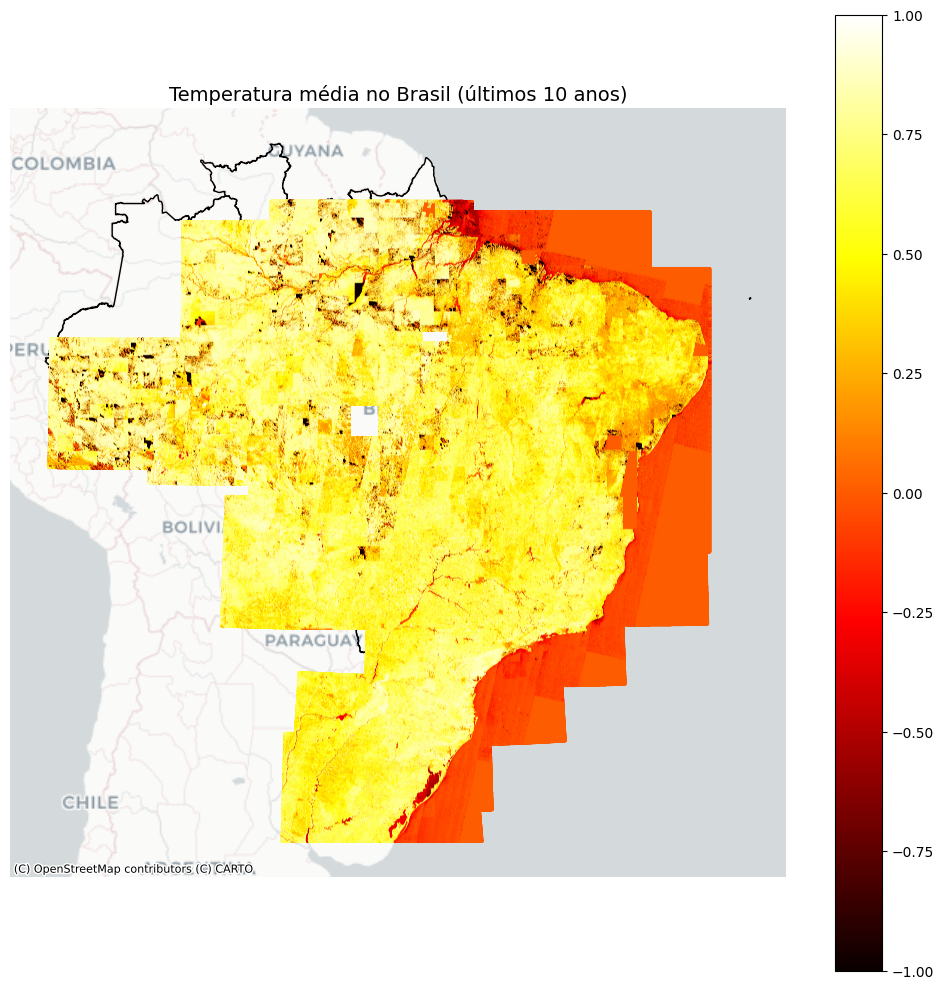

In [16]:
import contextily as ctx

gdf_brasil = gpd.read_file("./Dados/ShapeFile/br_states.json")

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf_temp = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

gdf_temp = gdf_temp.to_crs(epsg=3857)

gdf_brasil = gdf_brasil.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

gdf_brasil.plot(ax=ax, facecolor='none', edgecolor='black')

gdf_temp.plot(
    ax=ax,
    column='NDVI',
    cmap='hot',
    markersize=1,
    alpha=0.5,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Temperatura média no Brasil (últimos 10 anos)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [17]:
gdf_temp.plot(
    ax=ax,
    column='NDWI',
    cmap='hot',
    markersize=1,
    alpha=0.5,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Temperatura média no Brasil (últimos 10 anos)', fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

# Testes

## Curitiba

### Uma Imagem

In [ ]:


import rasterio
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from rasterio.windows import Window
from pyproj import Transformer
from rasterio.windows import from_bounds



latitude = -25.471107
longitude = -49.285757

tam_janela = 10

epsg_destino = 32722
epsg_origem = 4326
transformer = Transformer.from_crs(epsg_origem, epsg_destino,  always_xy=True)
transformer_inv = Transformer.from_crs(epsg_destino, epsg_origem, always_xy=True)

x_utm, y_utm = transformer.transform(longitude, latitude)

buffer_m = int(tam_janela/2) * 1000
minx, maxx = x_utm - buffer_m, x_utm + buffer_m
miny, maxy = y_utm - buffer_m, y_utm + buffer_m
lon_min, lat_min = transformer_inv.transform(minx, miny)
lon_max, lat_max = transformer_inv.transform(maxx, maxy)

extrairJanela("NDVI", "RdYlGn")
extrairJanela("NDWI", "RdYlBu")

In [ ]:
with rasterio.open(f"../../Dados/Imagens/Curitiba - Precisao/NDWI.tif") as src:
    janela = from_bounds(minx, miny, maxx, maxy, src.transform)
    ndwi = src.read(1)
    transform_janela = src.window_transform(janela)

with rasterio.open(f"../../Dados/Imagens/Curitiba - Precisao/NDVI.tif") as src:
    janela = from_bounds(minx, miny, maxx, maxy, src.transform)
    ndvi = src.read(1)

fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(ndvi, cmap="gray")
ax.set_title(f"Janela de {tam_janela} km")
ax.axis("off")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="gray"), ax=ax)
plt.show()

In [ ]:
with rasterio.open("../../Dados/Imagens/Curitiba - Precisao/2024-07-31-00_00_2025-01-31-23_59_Sentinel-2_L2A_B11_(Raw).tiff") as src:
    swir = src.read(1)
    
with rasterio.open("../../Dados/Imagens/Curitiba - Precisao/2024-07-31-00_00_2025-01-31-23_59_Sentinel-2_L2A_B08_(Raw).tiff") as src:
    nir = src.read(1)
    
    
    
ndbi = (swir - nir) / (swir + nir)

In [ ]:
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
from matplotlib.patches import Patch
class_mask = np.zeros_like(ndvi, dtype=np.uint8)

class_mask[ndwi > 0.2] = 1
class_mask[(ndvi > 0.5) & (ndwi <= 0.2)] = 2 
class_mask[(ndbi > 0.0 ) & (ndvi <= 0.5) & (ndwi <= 0.2)] = 3

colors = np.array([
    [255, 255, 255],  # Outro - branco
    [0, 0, 255],      # Água - azul
    [0, 128, 0],      # Vegetação - verde escuro
    [255, 100, 100],    # Construcao - vermelho claro
], dtype=np.uint8)
class_rgb = colors[class_mask]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(rgb)
axs[0].set_title("Imagem Original  - precisão ")
axs[0].axis("off")

axs[1].imshow(class_rgb)
axs[1].set_title("Classificação: Água, Vegetação e Contrução")
axs[1].axis("off")

# Legenda
legend_elements = [
    Patch(facecolor=np.array([0, 0, 255])/255, label='Água'),
    Patch(facecolor=np.array([0, 128, 0])/255, label='Vegetação'),
    Patch(facecolor=np.array([255, 100, 100])/255, label='Construcao'),
    Patch(facecolor=np.array([255, 255, 255])/255, label='Outro'),
]
axs[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

### Nuvens em várias imagens

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from scipy.ndimage import binary_closing, binary_fill_holes, label
from collections import deque
import os

In [ ]:
caminho = '../../Dados/Imagens/Curitiba - Precisao/'

todos_arquivos = []

for dirpath, dirnames, filenames in os.walk(caminho):
    arquivos = []
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        arquivos.append(full_path)
    todos_arquivos.append(arquivos)

In [ ]:

def normalizar(array):
    array_min, array_max = np.nanmin(array), np.nanmax(array)
    return ((array - array_min)/(array_max - array_min))


def calcularIndices(banda_x, banda_y, caminho, profile, nome):
    denominador = banda_x + banda_y
    # Evita divisão por zero substituindo 0 por um valor muito pequeno
    denominador[denominador == 0] = 1e-6
    indice = (banda_x - banda_y)/(denominador)
    salvarArquivo(indice, profile, caminho, nome)
    
def lerArquivo(arquivo):
    with rasterio.open(arquivo) as banda_src:
        img = banda_src.read(1)
        profile = banda_src.profile
    return img, profile
def lerArquivoRGB(arquivo):
    try:
        with rasterio.open(arquivo) as banda_src:            
            img = banda_src.read([1, 2, 3])
            rgb = np.transpose(img, (1, 2, 0))
            rgb /= rgb.max()
    except Exception as ex:
        print(f"Falha ao ler imagem RGB: {ex}")
        b2 = str(arquivo).replace("True_color", "B02_(Raw)")
        b3 = str(arquivo).replace("True_color", "B03_(Raw)")
        b4 = str(arquivo).replace("True_color", "B04_(Raw)")
   
        if not all([b2, b3, b4]):
            raise ValueError("Bandas B2, B3 e B4 são necessárias")
        with rasterio.open(b4) as r, \
          rasterio.open(b3) as g, \
          rasterio.open(b2) as b:
            red = r.read(1)
            green = g.read(1)
            blue = b.read(1)
            rgb = np.stack([red, green, blue], axis=-1)
            p2 = np.percentile(rgb, 2)   # elimina pixels muito escuros
            p98 = np.percentile(rgb, 98) # elimina pixels muito claros
            rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)
    
    return rgb

def salvarArquivo(dados, profile, caminho, nome):
    saida = os.path.join( os.path.dirname(caminho),  f"{nome}.tif")
    profile.update(dtype='float32', nodata=0)
    with rasterio.open(saida, 'w', **profile) as dst:
        dst.write(dados, 1)

def removerNuvens(cloud_mask, banda):
    return np.where(cloud_mask, np.nan, banda)

def plotarImagens(imagem, tc):
    cmap = plt.cm.YlGnBu.copy()
    cmap.set_bad(color='hotpink')

    fig, axs = plt.subplots(1,2, figsize=(20, 20))
    im0 = axs[0].imshow(imagem, cmap=cmap)
    axs[0].set_title('Banda Mascarada')
    axs[0].axis('off')
    
    im0 = axs[1].imshow(tc, cmap=cmap)
    axs[1].set_title('True Color')
    axs[1].axis('off')


### 

* 0	No Data (Missing data)
* 1	Saturated or defective pixel
* 2	Topographic casted shadows
* 3	Cloud shadows
* 4	Vegetation
* 5	Not-vegetated	
* 6	Water	
* 7	Unclassified	
* 8	Cloud medium probability
* 9	Cloud high probability	
* 10	Thin cirrus
* 11	Snow or ice

In [ ]:
def plotCategorias(img):
    classes = {
        0: 'No Data',
        1: 'Saturated or defective pixel',
        2: 'Topographic casted shadows',
        3: 'Cloud Shadows',
        4: 'Vegetation',
        5: 'Not vegetated',
        6: 'Water',
        7: 'Unclassified',
        8: 'Clouds medium probability',
        9: 'Clouds high probability',
        10: 'Thin Cirrus',
        11: 'Snow / Ice'
    }

    classes_presentes = {k: v for k, v in classes.items() if k in np.unique(img)}

    colors = [
        '#000000',  # 0 - Fundo
        '#7f7f7f',  # 1 - Não classificado
        '#6e6e6e',  # 2 - Sombra de nuvem
        '#99cc66',  # 3 - Vegetação baixa
        '#336633',  # 4 - Vegetação alta
        '#d2b48c',  # 5 - Solo nu
        '#3399ff',  # 6 - Água
        '#ffcc66',  # 7 - Nuvem média probabilidade
        '#ff9933',  # 8 - Nuvem alta probabilidade
        '#cce6ff',  # 9 - Cirros
        '#4d4d4d',  # 10 - Sombra de nuvem
        "#f3f3c9"   # 11 - Neve ou gelo
    ]
    cmap = mcolors.ListedColormap(colors)

    # Ajuste os limites para o BoundaryNorm
    boundaries = np.arange(-0.5, len(colors) + 0.5, 1)
    norm = mcolors.BoundaryNorm(boundaries, ncolors=len(colors))

    # Exemplo de imagem de classes (substitua pela sua)
    # img = np.random.randint(0, len(colors), size=(100, 100))
    # ou use sua própria matriz 'img'

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(img, cmap=cmap, norm=norm)
    # Legenda
    handles = []
    for value, label in classes_presentes.items():
        handles.append(
            plt.Line2D([0], [0], marker='s', color='w', label=f"{value}: {label}",
                    markerfacecolor=cmap(norm(value)), markersize=15)
        )

    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_title('Scene Classification Map')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def lerEPlotar(arquivo):
        with rasterio.open(arquivo) as banda_src:
                img = banda_src.read(1)

        img_classes = np.round(img * 11).astype(int)
        
        plotCategorias(img_classes)
        
        cloud_mask = np.isin(img_classes, [3,8,9,10])
        matriz = np.ones((5, 5)) 
        cloud_mask_buracos_fechados = binary_closing(cloud_mask, structure=matriz, iterations=3)

        cloud_mask_preenchida = binary_fill_holes(cloud_mask_buracos_fechados)
        
        
        return cloud_mask_preenchida

In [ ]:
def rgbTiraMascara(rgb, mask):
    # Expande a máscara para os 3 canais
    mask_3d = np.stack([mask]*3, axis=-1)  # shape (1599, 2500, 3)

    # Aplica fundo branco
    rgb_plot = rgb.copy()
    rgb_plot[mask_3d] = np.nan  # branco (ou qualquer outro valor)
    return rgb_plot
    

In [ ]:
b4, b3, b11, b8 = None, None, None, None

tc = []
for arquivos in todos_arquivos:
   print(arquivos[0])
   for arquivo in arquivos:
      
      if "B03" in arquivo:
         b3,_ = lerArquivo(arquivo)
      elif "B04" in arquivo:
         b4,_ = lerArquivo(arquivo)
      elif "B08" in arquivo:
         b8 ,_ = lerArquivo(arquivo)
      elif "Scene_classification_map" in arquivo:
         cloud_mask = lerEPlotar(arquivo)
      elif "True_color" in arquivo:
         tc.append(lerArquivoRGB(arquivo))
   if len(tc) != 0 and cloud_mask is not None:
      tc[-1] = rgbTiraMascara(tc[-1], cloud_mask)
      
   if b3 is not None and b4 is not None and b8 is not None and b11 is not None:
      b3 = removerNuvens(cloud_mask, b3)
      b4 = removerNuvens(cloud_mask, b4)
      b8 = removerNuvens(cloud_mask, b8)
      
      plotarImagens(b8, tc)
      plotarImagens(b8, tc)
      calcularIndices(b8, b4, arquivos[0], profile, "NDVI")
      calcularIndices(b3, b8, arquivos[0], profile, "NDWI")
    

In [ ]:
sum = 0
for i in tc:
    fig, axs = plt.subplots( figsize=(20, 20))
    plt.imshow(i)  # ou ajuste o dtype conforme sua imagem
    plt.axis('off')
    plt.show()

In [ ]:
pilha = np.stack(tc, axis=0)  # shape (3, altura, largura, 3)

antes = np.isnan(pilha).sum()
# Calcula a média ignorando NaN
media = np.nanmean(pilha, axis=0)  # shape (altura, largura, 3)
depois = np.isnan(media).sum()
fig, axs = plt.subplots( figsize=(20, 20))
plt.imshow(media)  # ou ajuste o dtype conforme sua imagem
plt.axis('off')
plt.show()

In [ ]:
caminho = '../../Dados/Imagens/Curitiba - Precisao/'


In [ ]:
ndvis = []
ndwis = []

for dirpath, dirnames, filenames in os.walk(caminho):
    arquivos = []
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        if filename.endswith('NDVI.tif'):
            with rasterio.open(full_path) as src:
                profile = src.profile
                ndvis.append(src.read(1))
        elif filename.endswith('NDWI.tif'):
            with rasterio.open(full_path) as src:
                ndwis.append(src.read(1))

In [ ]:
def plotImagensDeMedia(array, media, cor, metodo, profile):
    fig, ax = plt.subplots(1 , 3, figsize=(10, 10))
    for i, item in enumerate(array):
        ax[i].imshow(item, cmap=cor)
        ax[i].set_title(f"Imagem {i} - {metodo}")
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(media, cmap=cor)
    ax.set_title(f'Média {metodo}')
    ax.axis('off')
    fig.colorbar(im, ax=ax) 
    plt.tight_layout()
    plt.show()
    salvarArquivo(media, profile, caminho, f"{metodo} - Media")



In [ ]:

ndvi_media = np.nanmean(ndvis, axis=0)
plotImagensDeMedia(ndvis, ndvi_media, 'RdYlGn', "NDVI", profile)

ndwi_media = np.nanmean(ndwis, axis=0)
plotImagensDeMedia(ndwis, ndwi_media, 'RdYlBu', "NDWI", profile)


In [ ]:
from matplotlib.patches import Patch


class_mask = np.zeros_like(ndvi_media, dtype=np.uint8)

class_mask[ndvi_media > 0.25] = 1
class_mask[(ndwi_media > 0.25) & (ndvi_media <=  0.25)] = 2 
colors = np.array([
    [200, 200, 200],
    [0, 128, 50],
    [0, 50, 255],
], dtype=np.uint8)
class_rgb = colors[class_mask]
# Plot lado a lado
fig, axs = plt.subplots(figsize=(12, 6))

axs.imshow(class_rgb)
axs.set_title(" Água e Vegetação")
axs.axis("off")
legend_elements = [
    Patch(facecolor=np.array([0, 128, 0])/255, label='Vegetação'),
    Patch(facecolor=np.array([0, 100, 255])/255, label='Água'),
    Patch(facecolor=np.array([200, 200, 200])/255, label='Outro'),
]
axs.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.savefig(f"{caminho}/Comparação.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

## Manaus

In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from rasterio.windows import Window
from pyproj import Transformer
from rasterio.windows import from_bounds



latitude = -3.104070
longitude = -60.013500

tam_janela = 20

epsg_destino = 32721
epsg_origem = 4326
transformer = Transformer.from_crs(epsg_origem, epsg_destino,  always_xy=True)
transformer_inv = Transformer.from_crs(epsg_destino, epsg_origem, always_xy=True)

x_utm, y_utm = transformer.transform(longitude, latitude)

buffer_m = int(tam_janela/2) * 1000
minx, maxx = x_utm - buffer_m, x_utm + buffer_m
miny, maxy = y_utm - buffer_m, y_utm + buffer_m
lon_min, lat_min = transformer_inv.transform(minx, miny)
lon_max, lat_max = transformer_inv.transform(maxx, maxy)

extrairJanela("NDVI", "RdYlGn")
extrairJanela("NDWI", "RdYlBu")

In [ ]:
def extrairJanela(metodo, cor):
    with rasterio.open(f"../../Dados/Imagens/Manaus - Precisao/{metodo}.tif") as src:
        imagem = src.read()
    colormap = plt.get_cmap(cor)
    norm = Normalize(vmin=-1, vmax=1)
    imagem_single_band = imagem[0, :, :] 
    imagem_color = colormap(norm(imagem_single_band))
        
    fig, ax = plt.subplots(figsize=(8, 8))
    img = ax.imshow(imagem_color)
    ax.set_title(f"Janela de {tam_janela} km")
    ax.axis("off")
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, label=metodo)
    plt.show()

In [ ]:
from matplotlib.patches import Patch
def criaPNG(caminho, ndwi_uma_banda, ndvi_uma_banda, ndbi_uma_banda, rgb):
    class_mask = np.zeros_like(ndvi_uma_banda, dtype=np.uint8)

    class_mask[ndwi_uma_banda > 0.25] = 1
    class_mask[(ndvi_uma_banda > 0.5) & (ndwi_uma_banda <=  0.25)] = 2 
    class_mask[(ndbi_uma_banda > 0) & (ndvi_uma_banda <= 0.5) & (ndwi_uma_banda <=  0.25)] = 3

    colors = np.array([
        [255, 255, 255],  # Outro - branco
        [0, 0, 255],      # Água - azul
        [0, 128, 0],      # Vegetação - verde escuro
        [255, 100, 100],    # Construcao - vermelho claro
    ], dtype=np.uint8)
    class_rgb = colors[class_mask]


    # Plot lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].imshow(rgb)
    axs[0].set_title("Imagem Original")
    axs[0].axis('off')


    axs[1].imshow(class_rgb)
    axs[1].set_title("Classificação: Água, Vegetação e Contrução")
    axs[1].axis("off")

    # Legenda
    legend_elements = [
        Patch(facecolor=np.array([0, 0, 255])/255, label='Água'),
        Patch(facecolor=np.array([0, 128, 0])/255, label='Vegetação'),
        Patch(facecolor=np.array([255, 100, 100])/255, label='Construcao'),
        Patch(facecolor=np.array([255, 255, 255])/255, label='Outro'),
    ]
    axs[1].legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig(f"{caminho}/Comparação.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
for arquivos in caminho_para_arquivos:
    print(arquivos)
    if 'LandSat' in arquivos[0] or 'MODIS' in arquivos[0]:
        continue
    ndvi = [a for a in arquivos if "NDVI" in a][0]
    ndbi = [a for a in arquivos if "NDBI" in a][0]
    ndwi = [a for a in arquivos if "NDWI" in a][0]
    true = [a for a in arquivos if "True_color" in a][0]
    
    with rasterio.open(ndwi) as src:
        ndwi = src.read()
    ndwi_uma_banda = ndwi[0, :, :]

    with rasterio.open(ndvi) as src:
        ndvi = src.read()
    ndvi_uma_banda = ndvi[0, :, :]

    with rasterio.open(ndbi) as src:
        ndbi = src.read()
    ndbi_uma_banda = ndbi[0, :, :]
    
    
    try:
        with rasterio.open(true) as banda_src:            
            img = banda_src.read([1, 2, 3])
            rgb = np.transpose(img, (1, 2, 0))
    except Exception as ex:
        print(f"Falha ao ler imagem RGB: {ex}")
        b2 = str(true).replace("True_color", "B02_(Raw)")
        b3 = str(true).replace("True_color", "B03_(Raw)")
        b4 = str(true).replace("True_color", "B04_(Raw)")
   
        if not all([b2, b3, b4]):
            raise ValueError("Bandas B2, B3 e B4 são necessárias")
        with rasterio.open(b4) as r, \
          rasterio.open(b3) as g, \
          rasterio.open(b2) as b:
            red = r.read(1)
            green = g.read(1)
            blue = b.read(1)
            rgb = np.stack([red, green, blue], axis=-1)
            

    rgb = rgb.astype(float)
    rgb /= rgb.max()
    criaPNG(arquivos[0], ndwi_uma_banda, ndvi_uma_banda, ndbi_uma_banda, rgb)
    

## TESTe baixando imagens

In [ ]:
import rasterio
from rasterio.merge import merge
from collections import defaultdict
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np

In [ ]:
landsat_path = '../../Dados/Imagens/Curitiba/LandSat/'

caminho_para_arquivos = []
for root, cidades, arquivos in os.walk(landsat_path):
    caminho_fotos = []
    for arquivo in arquivos:
        caminho_fotos.append(os.path.join(root, arquivo))
    if(len(caminho_fotos) > 0):
        caminho_para_arquivos.append(caminho_fotos)

In [ ]:
def pegaSufixo(filename):
    base = os.path.basename(filename)
    name_without_ext = os.path.splitext(base)[0]
    parts = name_without_ext.split('_')
    return parts[-1]


bandas = defaultdict(list)
for f in caminho_para_arquivos[0]:
    if "TIF" in f:
        sufixo = pegaSufixo(f)
        bandas[sufixo].append(f)


for sufixo, files in bandas.items():
    print(f"{sufixo}: {len(files)} arquivos")


In [ ]:

def criaMosaico(banda, lista):
    # Abre todos os arquivos
    src_files_to_mosaic = [rasterio.open(fp) for fp in lista]

    # Faz o mosaico
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Pega o perfil (metadados) do primeiro raster para basear o novo arquivo
    out_meta = src_files_to_mosaic[0].meta.copy()

    # Atualiza os metadados para refletir o mosaico
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
    })

    pasta_saida = os.path.join( os.path.dirname(lista[0]),"bandas-separadas")
    if not os.path.exists(pasta_saida):
        os.makedirs(pasta_saida)
    saida = os.path.join( pasta_saida,  f"{banda}.tif")
    
    with rasterio.open(saida, "w", **out_meta) as dest:
        dest.write(mosaic)

    for src in src_files_to_mosaic:
        src.close()

    print(f"Mosaico criado em: {saida}")

In [ ]:
for banda, arquivos in bandas.items():
    print(f"banda: {banda}")
    criaMosaico(banda, arquivos)

In [ ]:
mosaicos = landsat_path + '/bandas-separadas'

with rasterio.open(os.path.join(mosaicos, 'PIXEL.TIF')) as src:
    qa_pixel = src.read(1) 



In [ ]:
cloud_mask = np.bitwise_or((qa_pixel & (1 << 3)) != 0, (qa_pixel & (1 << 4)) != 0)


In [ ]:
def rgb(arquivo):

    # Load Blue (B2), Green (B3) and Red (B4) bands
    B2 = tiff.imread(os.path.join(landsat_path, f"{arquivo}B2.tif"))
    B3 = tiff.imread(os.path.join(landsat_path, f"{arquivo}B3.tif"))
    B4 = tiff.imread(os.path.join(landsat_path, f"{arquivo}B4.tif"))

    # Stack and scale bands
    RGB = np.dstack((B4, B3, B2))
    RGB = np.clip(RGB*0.0000275-0.2, 0, 1)

    # Clip to enhance contrast
    RGB = np.clip(RGB,0,0.3)/0.3

    return RGB

In [ ]:
arquivo = 'LC08_L1GT_220078_20250128_20250131_02_T2_'
RGB = rgb(arquivo)

# Plot the RGB image
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(RGB)

In [ ]:
def mascara_nuvem(val,type='cloud'):
    print(type)
    bits = {'cloud':3,'shadow':4,'dilated_cloud':1,'cirrus':2}
    return (val & (1 << bits[type])) != 0

In [ ]:
QA = tiff.imread(f"{landsat_path}/{arquivo}QA_PIXEL.TIF")
QA = np.array(QA)

# Get masks
cloud_mask = mascara_nuvem(QA,type='cloud')
shadow_mask =  mascara_nuvem(QA,type='shadow')
dilated_cloud_mask =  mascara_nuvem(QA,type='dilated_cloud')
cirrus_mask =  mascara_nuvem(QA,type='cirrus')

In [ ]:
import cv2
import matplotlib as mpl

# segmentation image
seg = RGB.copy()

# color for each cover type
colors = np.array([[247, 2, 7],
                    [201, 116, 247],
                    [0, 234, 255],
                    [3, 252, 53]])/255

masks = [cloud_mask, shadow_mask, dilated_cloud_mask, cirrus_mask]

for i,mask in enumerate(masks):

    # color for cover type
    temp = seg.copy()
    temp[mask == 0] = colors[i]

    # add to segmentation
    seg = cv2.addWeighted(seg, 0.5, temp, 0.5, 0)

fig, ax = plt.subplots(figsize=(20, 10))

ax.imshow(seg)

legend_elements = [mpl.patches.Patch(facecolor=colors[0], label='Cloud'),
                     mpl.patches.Patch(facecolor=colors[1], label='Shadow'),
                        mpl.patches.Patch(facecolor=colors[2], label='Dilated Cloud'),
                        mpl.patches.Patch(facecolor=colors[3], label='Cirrus')]

ax.legend(handles=legend_elements, loc='upper right')


ax.set_axis_off()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = cloud_mask*shadow_mask*dilated_cloud_mask*cirrus_mask
ax.imshow(mask)


## Google API

In [ ]:
def maskL8sr(image):
    # Selecionar a banda de QA_PIXEL
    qa = image.select('QA_PIXEL')
    
    # Definir os bits que queremos mascarar (bit 3 = nuvens, bit 4 = sombra)
    cloud = qa.bitwiseAnd(1 << 3).eq(0)
    shadow = qa.bitwiseAnd(1 << 4).eq(0)
    
    # Combinar as máscaras
    mask = cloud.And(shadow)
    
    return image.updateMask(mask)


In [ ]:
import ee


ee.Authenticate()
ee.Initialize(project='speedy-web-339719')

# Definir região e datas
roi = ee.Geometry.Point([ -49.28, -25.47]).buffer(10000)
start_date = '2025-01-01'
end_date = '2025-03-31'

# Carregar coleção Landsat 8
collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
              .filterBounds(roi)
              .filterDate(start_date, end_date)
              .map(maskL8sr))

count = collection.size().getInfo()
print(f'Número de imagens encontradas: {count}')

if count > 0:
    first_image = collection.first()
    print(first_image.bandNames().getInfo())
else:
    print("Nenhuma imagem encontrada!")
    
median_image = collection.median()

# Exportar
task = ee.batch.Export.image.toDrive(
    image=median_image.clip(roi),
    description='Landsat8_CloudFree',
    folder='GEE_Export',
    fileNamePrefix='Landsat8_CloudFree',
    region=roi,
    scale=30,
    fileFormat='GeoTIFF'
)
task.start()
print("Exportação iniciada!")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

image = collection.first().select('SR_B4')

thumb_url = image.getThumbURL({
    'region': roi,
    'min': 0,
    'max': 3000,
    'dimensions': 512,
    'format': 'png',
    'bands': ['SR_B4']
})

response = requests.get(thumb_url)
img = Image.open(BytesIO(response.content))

arr = np.asarray(img)

if arr.ndim == 3 and arr.shape[2] >= 2:
    arr = arr[:, :, 0]

# Plota
plt.figure(figsize=(8, 8))
plt.imshow(arr, cmap='gray')
plt.axis('off')
plt.title('Landsat 8 - Banda 4')
plt.show()

In [ ]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
import geopandas as gpd
from pyhdf import SD, SDC

filename = '../../Dados/Imagens/Curitiba/MODIS/MOD13Q1.A2025017.h13v11.061.2025035161434.hdf'



filename = 'MOD13Q1.A2025017.h13v11.061.2025035161434.hdf'
hdf = SD(filename, SDC.READ)

# Verifique os subdatasets:
datasets = hdf.datasets()
print("Datasets:", datasets)

# Carregue um dataset:
data = hdf.select('NDVI')  # por exemplo
ndvi_data = data.get()
print(ndvi_data.shape)

In [ ]:
modis_pre_qa = modis_pre[0]
modis_pre_qa